## Импорты

In [ ]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import json
import csv
from typing import Dict, Any, List, Tuple
import time
import uuid
from torch.optim import Optimizer

In [ ]:
from collections import defaultdict

## Выгрузка файлов

In [ ]:
drive.mount('/content/drive')

DRIVE_DOGS_PATH = "/content/drive/MyDrive/ThuDogs"
LOCAL_DOGS_PATH = "/content/ThuDogs"
os.makedirs(LOCAL_DOGS_PATH, exist_ok=True)

def unzip_dogs_if_needed(zip_name, extract_to):
    zip_path = os.path.join(DRIVE_DOGS_PATH, zip_name)
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Файл не найден: {zip_path}")
    os.makedirs(extract_to, exist_ok=True)
    if not os.listdir(extract_to):
        print(f"Распаковка {zip_name}...")
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_to)
        print("Готово!")
    else:
        print(f"{extract_to} уже распакован — пропускаем.")
unzip_dogs_if_needed("low-resolution.zip", os.path.join(LOCAL_DOGS_PATH, "images"))
unzip_dogs_if_needed("TrainValSplit.zip", os.path.join(LOCAL_DOGS_PATH, "splits"))

Mounted at /content/drive
Распаковка low-resolution.zip...
Готово!
Распаковка TrainValSplit.zip...
Готово!


# Датасет

In [ ]:
class BalancedSubsetDataset(Dataset):
    def __init__(self, root_img_dir, split_file, transform=None, fraction=0.2, seed=42):
        """
        :param fraction: доля изображений, выбираемых из каждого класса (например, 0.2 = 20%)
        :param seed: для воспроизводимости
        """
        self.root_img_dir = root_img_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.fraction = fraction
        self.seed = seed
        with open(split_file, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        class_to_paths = defaultdict(list)
        for rel_path in lines:
            rel_path_clean = rel_path.lstrip('./')
            class_name = rel_path_clean.split('/')[0]
            full_path = os.path.join(root_img_dir, rel_path_clean)
            if os.path.exists(full_path):
                class_to_paths[class_name].append(rel_path_clean)
        random.seed(seed)
        self.samples = []
        for class_name, paths in class_to_paths.items():
            n_keep = max(1, int(len(paths) * fraction))
            sampled_paths = random.sample(paths, n_keep)
            self.samples.extend([(os.path.join(root_img_dir, p), class_name) for p in sampled_paths])
        unique_classes = sorted(set(class_name for _, class_name in self.samples))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
        self.classes = unique_classes
        self.samples = [(path, self.class_to_idx[cls]) for path, cls in self.samples]
        print(f"Загружено {len(self.samples)} изображений ({fraction*100:.0f}% из каждого класса)")
        print(f"Число классов: {len(self.classes)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label



# Квантизация

In [ ]:
class LSQQuantizer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, step_size, bit_width=8):
        Qn = -(2 ** (bit_width - 1))
        Qp = (2 ** (bit_width - 1)) - 1
        x_scaled = x / step_size
        x_clamped = torch.clamp(x_scaled, Qn, Qp)
        x_quant = torch.round(x_clamped) * step_size
        ctx.save_for_backward(x, step_size)
        ctx.Qn_val = Qn
        ctx.Qp_val = Qp
        ctx.Qp_tensor = torch.tensor(Qp, dtype=x.dtype, device=x.device)
        return x_quant

    @staticmethod
    def backward(ctx, grad_output):
        x, step_size = ctx.saved_tensors
        Qn_val = ctx.Qn_val
        Qp_val = ctx.Qp_val
        Qp_tensor = ctx.Qp_tensor
        grad_x = grad_output.clone()
        x_scaled = x / step_size
        indicator = (x_scaled >= Qn_val) & (x_scaled <= Qp_val)
        grad_step = ((grad_output * torch.sign(x) * indicator).sum()) / torch.sqrt(Qp_tensor)
        return grad_x, grad_step, None

In [ ]:
class LSQConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 weight_bit=8, act_bit=8, bias=True):
        super().__init__()
        self.weight_bit = weight_bit
        self.act_bit = act_bit
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.weight_step = nn.Parameter(torch.tensor(1e-3))
        self.act_step = nn.Parameter(torch.tensor(1e-3))
        self.quantizer = LSQQuantizer.apply
        self.weight_init = False
        self.act_init = False

    def forward(self, x):
        if not self.weight_init:
            Qp = 2 ** (self.weight_bit - 1) - 1
            self.weight_step.data = torch.tensor(2 * self.conv.weight.std().item() / (Qp ** 0.5))
            self.weight_init = True
        w_quant = self.quantizer(self.conv.weight, self.weight_step, self.weight_bit)
        out = F.conv2d(x, w_quant, self.conv.bias, self.conv.stride, self.conv.padding)
        if not self.act_init:
            Qp = 2 ** (self.act_bit - 1) - 1
            self.act_step.data = torch.tensor(2 * out.std().item() / (Qp ** 0.5))
            self.act_init = True
        out_quant = self.quantizer(out, self.act_step, self.act_bit)
        return out_quant

In [ ]:
def replace_conv_with_lsq(module, bit_width=8):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            in_ch = child.in_channels
            out_ch = child.out_channels
            k = child.kernel_size
            s = child.stride
            p = child.padding
            b = child.bias is not None

            lsq_conv = LSQConv2d(in_ch, out_ch, k, s, p, bias=b, weight_bit=bit_width, act_bit=bit_width)
            lsq_conv.conv.weight.data.copy_(child.weight.data)
            if b:
                lsq_conv.conv.bias.data.copy_(child.bias.data)

            setattr(module, name, lsq_conv)
        else:
            replace_conv_with_lsq(child, bit_width)

In [ ]:
def create_resnet18_lsq(num_classes, bit_width=8):
    import torchvision.models as models
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    replace_conv_with_lsq(model, bit_width=bit_width)
    return model

# Оптимизаторы

In [ ]:
def train_and_get_history_cls(
    ModelClass, OptimizerClass, opt_params, batch_size, epochs, seed, device, log_path=None
):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    train_dataset = BalancedSubsetDataset(
        root_img_dir="/content/ThuDogs/images/low-resolution",
        split_file="/content/ThuDogs/splits/TrainAndValList/train.lst",
        fraction=0.01,
        seed=seed
    )
    valid_dataset = BalancedSubsetDataset(
        root_img_dir="/content/ThuDogs/images/low-resolution",
        split_file="/content/ThuDogs/splits/TrainAndValList/validation.lst",
        fraction=0.01,
        seed=seed
    )

    model = ModelClass(num_classes=len(train_dataset.classes), bit_width=8).to(device)
    optimizer = OptimizerClass(model.parameters(), **opt_params)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

    acc_history = []
    loss_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(train_dataset)
        loss_history.append(avg_loss)

        model.eval()
        correct = 0
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
        acc = 100.0 * correct / len(valid_dataset)
        acc_history.append(acc)

        if log_path:
            with open(log_path, 'a') as f:
                f.write(f"{epoch},{avg_loss:.4f},{acc:.2f}\n")
        print(f"    [Эпоха {epoch}/{epochs}] Loss: {avg_loss:.4f}, Acc: {acc:.2f}%")

    return acc_history, loss_history

In [ ]:
def run_single_experiment_cls(
    task_name: str,
    optimizer_name: str,
    batch_size: int,
    learning_rate: float,
    epochs: int,
    seed: int,
    log_file_path: str,
    ModelClass: Any,
    OptimizerClass: Any,
    device: torch.device,
    opt_params_extra: Dict[str, Any] = None
) -> Dict[str, Any]:
    start_time = time.time()
    run_id = str(uuid.uuid4())

    print(f"\nЗапуск (BS={batch_size}, LR={learning_rate:.1e}, Seed={seed})")

    opt_params = {"lr": learning_rate}
    if opt_params_extra:
        opt_params.update(opt_params_extra)

    metric_history, loss_history = train_and_get_history_cls(
        ModelClass=ModelClass,
        OptimizerClass=OptimizerClass,
        opt_params=opt_params,
        batch_size=batch_size,
        epochs=epochs,
        seed=seed,
        device=device,
        log_path=log_file_path
    )
    if not metric_history:
        return {}

    best_metric = max(metric_history)
    best_epoch = metric_history.index(best_metric) + 1
    final_metric = metric_history[-1]
    mean_metric = np.mean(metric_history)

    end_time = time.time()
    total_time_sec = round(end_time - start_time, 2)

    return {
        'run_id': run_id,
        'task_name': task_name,
        'model_name': 'ResNet18_LSQ',
        'optimizer': optimizer_name,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'seed': seed,
        'log_file_path': log_file_path,
        'mean_metric_all_epochs': float(mean_metric),
        'best_metric': float(best_metric),
        'best_epoch': best_epoch,
        'final_metric': float(final_metric),
        'total_time_sec': total_time_sec,
        'metric_history': [float(m) for m in metric_history],
        'loss_history': [float(l) for l in loss_history],
    }

In [ ]:
EXPERIMENT_ROOT = "/content/drive/MyDrive/CLS_ResNet18_LSQ_Experiments"
TASK_NAME = "Classification"
EPOCHS = 6
SEEDS = [21, 42, 101, 77, 123, 500, 601, 802, 903, 1004]
batch_sizes = [8, 16]
learning_rates = [1e-4, 5e-4, 1e-3]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Adam


In [ ]:
OPTIMIZER_NAME = "Adam"
OptimizerClass = torch.optim.Adam
opt_params_extra = {}

OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
from collections import defaultdict

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")

            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.2174, Acc: 1.54%
    [Эпоха 2/6] Loss: 3.4932, Acc: 3.08%
    [Эпоха 3/6] Loss: 3.2539, Acc: 1.54%
    [Эпоха 4/6] Loss: 2.9752, Acc: 2.31%
    [Эпоха 5/6] Loss: 2.7056, Acc: 3.85%
    [Эпоха 6/6] Loss: 2.3303, Acc: 2.31%
  > BS=8, LR=1e-04, Seed=21: Acc = 3.85%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.2103, Acc: 0.77%
    [Эпоха 2/6] Loss: 3.5163, Acc: 2.31%
    [Эпоха 3/6] Loss: 3.2399, Acc: 1.54%
    [Эпоха 4/6] Loss: 2.9806, Acc: 1.54%
    [Эпоха 5/6] Loss: 2.6847, Acc: 1.54%
    [Эпоха 6/6] Loss: 2.3767, Acc: 2.31%
  > BS=8, LR=1e-04, Seed=42: Acc = 2.31%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")



Все результаты сохранены в ALL_RESULTS_Adam_full.json.


In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_Adam_full.json.
Лучшая конфигурация (Adam): BS=8, LR=1e-04 → Средняя Acc = 1.33%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (Adam): Acc = 1.23 ± 0.78%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

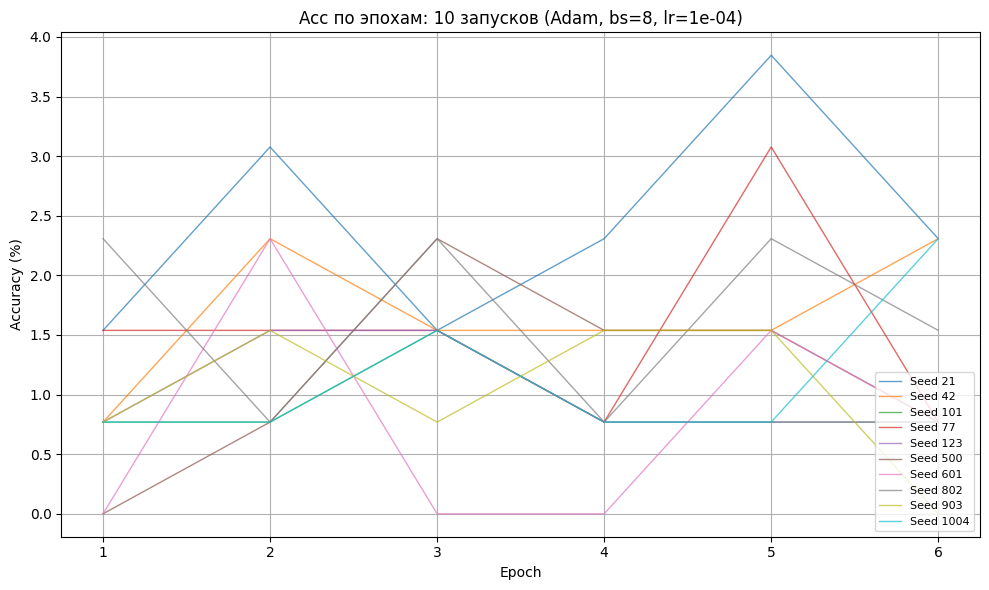

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

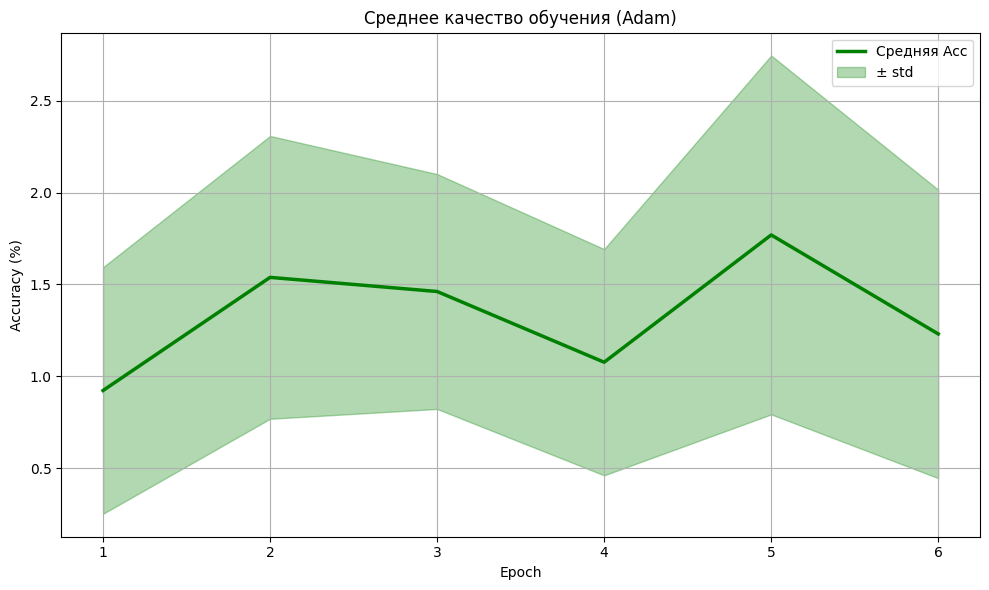

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

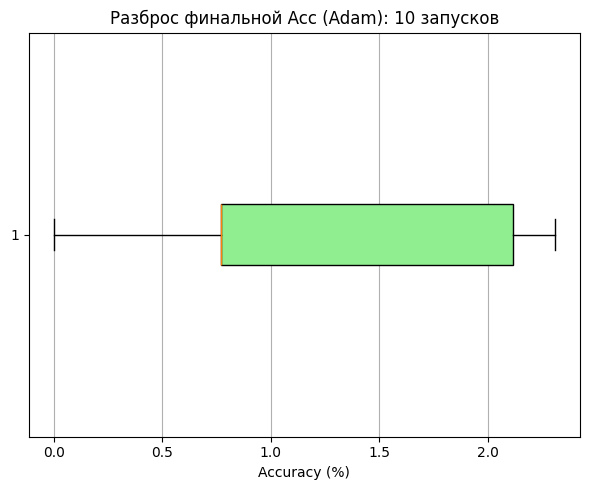

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

## SGD

In [ ]:
OPTIMIZER_NAME = "SGD"
OptimizerClass = torch.optim.SGD
opt_params_extra = {"momentum": 0.9}

OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")
            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.6539, Acc: 0.77%
    [Эпоха 2/6] Loss: 4.1063, Acc: 0.77%
    [Эпоха 3/6] Loss: 3.9092, Acc: 0.77%
    [Эпоха 4/6] Loss: 3.8018, Acc: 0.77%
    [Эпоха 5/6] Loss: 3.7500, Acc: 0.77%
    [Эпоха 6/6] Loss: 3.7104, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=21: Acc = 0.77%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.6039, Acc: 0.77%
    [Эпоха 2/6] Loss: 4.0784, Acc: 0.77%
    [Эпоха 3/6] Loss: 3.8698, Acc: 0.77%
    [Эпоха 4/6] Loss: 3.7797, Acc: 0.77%
    [Эпоха 5/6] Loss: 3.7435, Acc: 0.77%
    [Эпоха 6/6] Loss: 3.7123, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=42: Acc = 0.77%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")



Все результаты сохранены в ALL_RESULTS_SGD_full.json.


In [ ]:
search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_SGD_full.json.
Лучшая конфигурация (SGD): BS=16, LR=1e-03 → Средняя Acc = 0.96%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (SGD): Acc = 1.00 ± 0.60%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

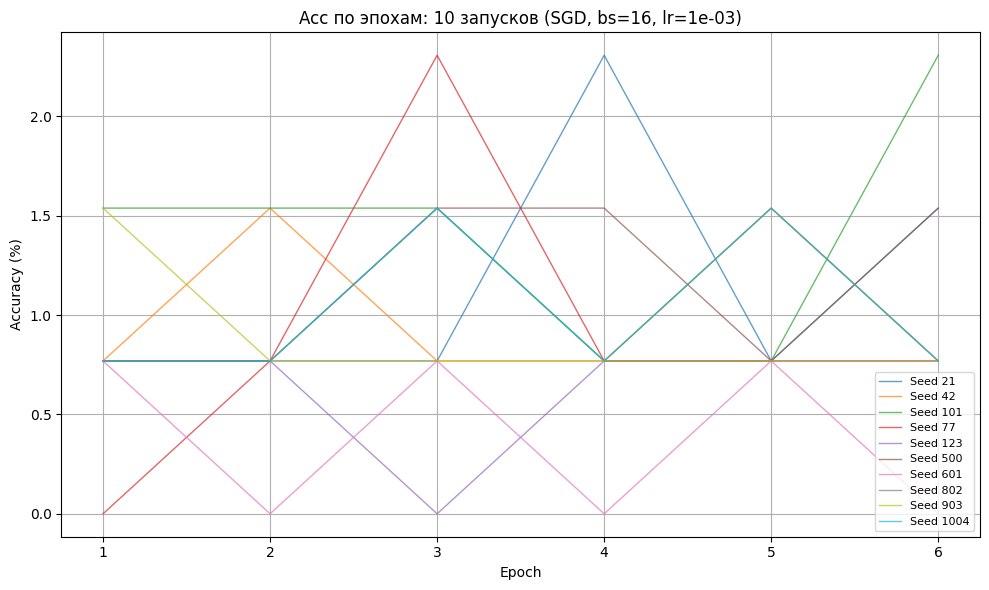

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

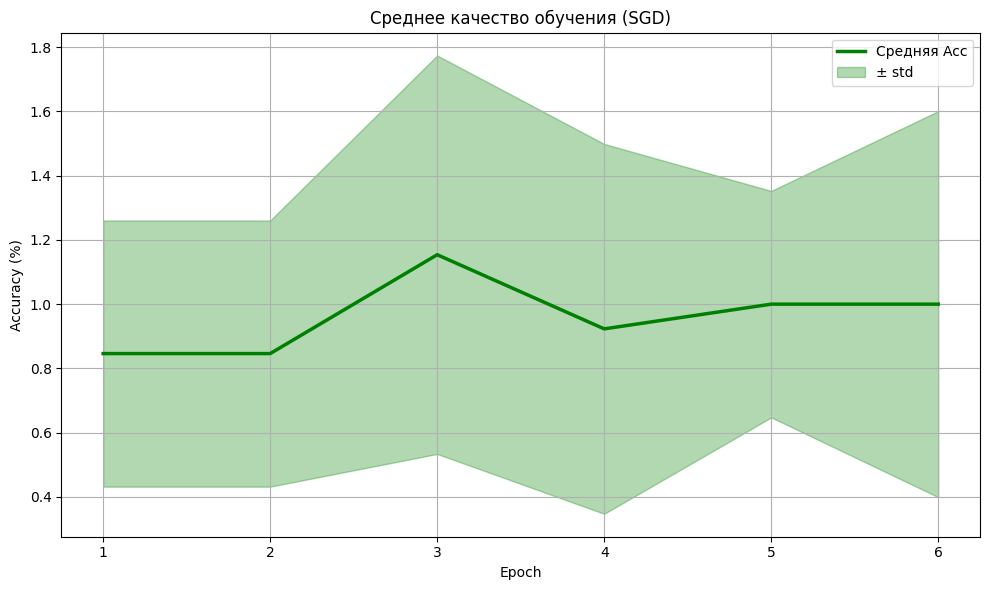

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

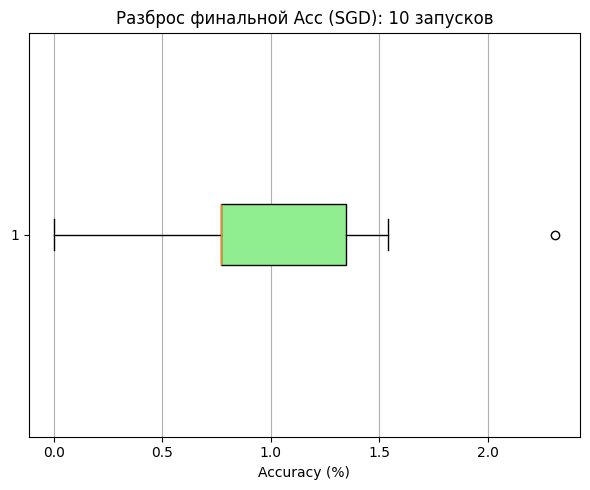

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

## Nesterov Momentum

In [ ]:
OPTIMIZER_NAME = "Nesterov"
OptimizerClass = torch.optim.SGD
opt_params_extra = {"momentum": 0.9, "nesterov": True}

OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")
            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.6432, Acc: 0.77%
    [Эпоха 2/6] Loss: 4.1017, Acc: 0.77%
    [Эпоха 3/6] Loss: 3.8938, Acc: 1.54%
    [Эпоха 4/6] Loss: 3.7813, Acc: 0.77%
    [Эпоха 5/6] Loss: 3.7455, Acc: 0.77%
    [Эпоха 6/6] Loss: 3.7053, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=21: Acc = 1.54%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.5943, Acc: 0.77%
    [Эпоха 2/6] Loss: 4.0844, Acc: 0.77%
    [Эпоха 3/6] Loss: 3.8794, Acc: 0.77%
    [Эпоха 4/6] Loss: 3.7884, Acc: 0.77%
    [Эпоха 5/6] Loss: 3.7508, Acc: 0.77%
    [Эпоха 6/6] Loss: 3.7136, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=42: Acc = 0.77%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")



Все результаты сохранены в ALL_RESULTS_Nesterov_full.json.


In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_Nesterov_full.json.
Лучшая конфигурация (Nesterov): BS=8, LR=1e-03 → Средняя Acc = 0.88%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (Nesterov): Acc = 0.92 ± 0.46%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

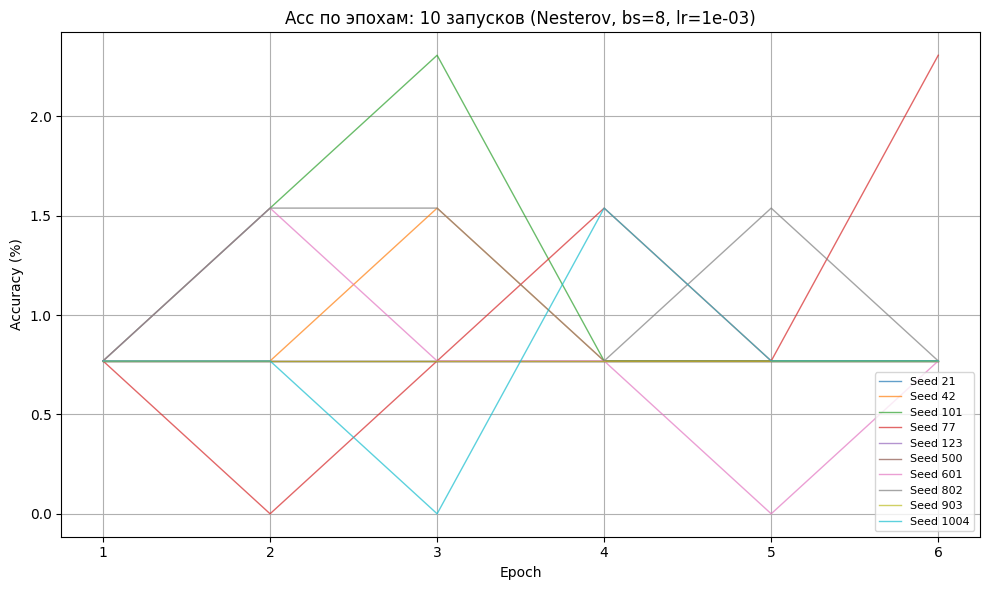

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

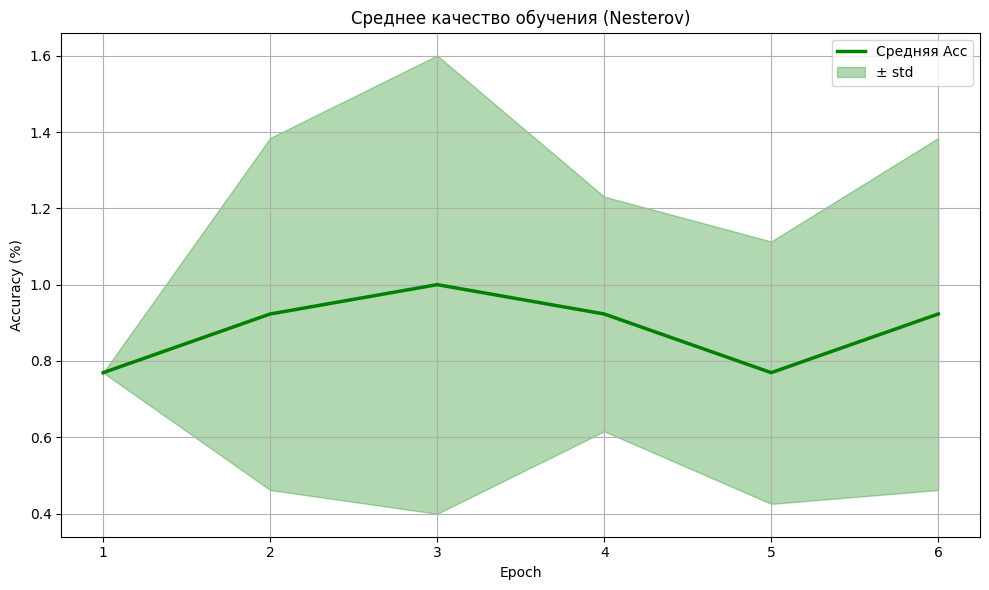

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

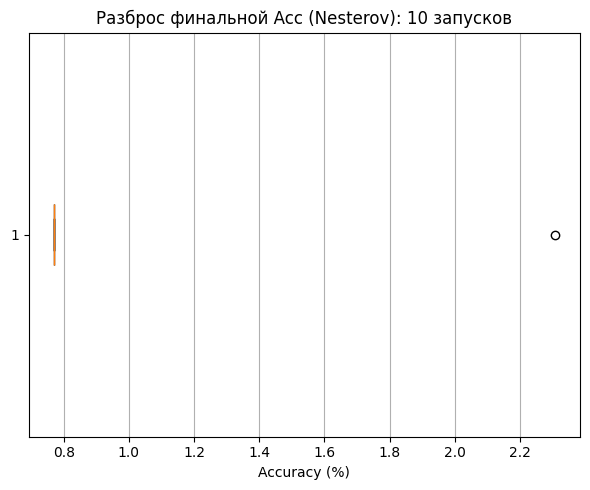

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

## AdaGrad

In [ ]:
class LSQConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 weight_bit=8, act_bit=8, bias=True, device=None):
        super().__init__()
        self.weight_bit = weight_bit
        self.act_bit = act_bit
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)

        # ✅ Инициализируем параметры на нужном устройстве
        self.weight_step = nn.Parameter(torch.tensor(1e-3, device=device))
        self.act_step = nn.Parameter(torch.tensor(1e-3, device=device))

        self.quantizer = LSQQuantizer.apply
        self.weight_init = False
        self.act_init = False

    def forward(self, x):
        if not self.weight_init:
            Qp = 2 ** (self.weight_bit - 1) - 1
            # ✅ Убедимся, что std вычисляется на том же устройстве, что и веса
            std = self.conv.weight.std().item()
            self.weight_step.data = torch.tensor(2 * std / (Qp ** 0.5), device=self.weight_step.device)
            self.weight_init = True

        w_quant = self.quantizer(self.conv.weight, self.weight_step, self.weight_bit)
        out = F.conv2d(x, w_quant, self.conv.bias, self.conv.stride, self.conv.padding)

        if not self.act_init:
            Qp = 2 ** (self.act_bit - 1) - 1
            # ✅ Убедимся, что std вычисляется на том же устройстве, что и активации
            std = out.std().item()
            self.act_step.data = torch.tensor(2 * std / (Qp ** 0.5), device=self.act_step.device)
            self.act_init = True

        out_quant = self.quantizer(out, self.act_step, self.weight_bit)
        return out_quant

In [ ]:
def replace_conv_with_lsq(module, bit_width=8, device=None):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            in_ch = child.in_channels
            out_ch = child.out_channels
            k = child.kernel_size
            s = child.stride
            p = child.padding
            b = child.bias is not None

            lsq_conv = LSQConv2d(
                in_ch, out_ch, k, s, p, bias=b, weight_bit=bit_width, act_bit=bit_width, device=device
            )
            lsq_conv.conv.weight.data.copy_(child.weight.data)
            if b:
                lsq_conv.conv.bias.data.copy_(child.bias.data)

            setattr(module, name, lsq_conv)
        else:
            replace_conv_with_lsq(child, bit_width, device)

def create_resnet18_lsq(num_classes, bit_width=8, device=None):
    import torchvision.models as models
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    replace_conv_with_lsq(model, bit_width=bit_width, device=device)
    return model

In [ ]:
OPTIMIZER_NAME = "AdaGrad"
OptimizerClass = torch.optim.Adagrad
opt_params_extra = {}

OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
def train_and_get_history_cls(
    ModelClass, OptimizerClass, opt_params, batch_size, epochs, seed, device, log_path=None
):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    train_dataset = BalancedSubsetDataset(
        root_img_dir="/content/ThuDogs/images/low-resolution",
        split_file="/content/ThuDogs/splits/TrainAndValList/train.lst",
        fraction=0.01,
        seed=seed
    )
    valid_dataset = BalancedSubsetDataset(
        root_img_dir="/content/ThuDogs/images/low-resolution",
        split_file="/content/ThuDogs/splits/TrainAndValList/validation.lst",
        fraction=0.01,
        seed=seed
    )

    # ✅ Передаём device в модель
    model = ModelClass(num_classes=len(train_dataset.classes), bit_width=8, device=device).to(device)
    optimizer = OptimizerClass(model.parameters(), **opt_params)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

    acc_history = []
    loss_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(train_dataset)
        loss_history.append(avg_loss)

        model.eval()
        correct = 0
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
        acc = 100.0 * correct / len(valid_dataset)
        acc_history.append(acc)

        if log_path:
            with open(log_path, 'a') as f:
                f.write(f"{epoch},{avg_loss:.4f},{acc:.2f}\n")
        print(f"    [Эпоха {epoch}/{epochs}] Loss: {avg_loss:.4f}, Acc: {acc:.2f}%")

    return acc_history, loss_history

In [ ]:
def run_single_experiment_cls(
    task_name: str,
    optimizer_name: str,
    batch_size: int,
    learning_rate: float,
    epochs: int,
    seed: int,
    log_file_path: str,
    ModelClass: Any,
    OptimizerClass: Any,
    device: torch.device,
    opt_params_extra: Dict[str, Any] = None
) -> Dict[str, Any]:
    start_time = time.time()
    run_id = str(uuid.uuid4())

    print(f"\nЗапуск (BS={batch_size}, LR={learning_rate:.1e}, Seed={seed})")

    opt_params = {"lr": learning_rate}
    if opt_params_extra:
        opt_params.update(opt_params_extra)

    metric_history, loss_history = train_and_get_history_cls(
        ModelClass=ModelClass,
        OptimizerClass=OptimizerClass,
        opt_params=opt_params,
        batch_size=batch_size,
        epochs=epochs,
        seed=seed,
        device=device,
        log_path=log_file_path
    )
    if not metric_history:
        return {}

    best_metric = max(metric_history)
    best_epoch = metric_history.index(best_metric) + 1
    final_metric = metric_history[-1]
    mean_metric = np.mean(metric_history)

    end_time = time.time()
    total_time_sec = round(end_time - start_time, 2)

    return {
        'run_id': run_id,
        'task_name': task_name,
        'model_name': 'ResNet18_LSQ',
        'optimizer': optimizer_name,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'seed': seed,
        'log_file_path': log_file_path,
        'mean_metric_all_epochs': float(mean_metric),
        'best_metric': float(best_metric),
        'best_epoch': best_epoch,
        'final_metric': float(final_metric),
        'total_time_sec': total_time_sec,
        'metric_history': [float(m) for m in metric_history],
        'loss_history': [float(l) for l in loss_history],
    }

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")
            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.6279, Acc: 1.54%
    [Эпоха 2/6] Loss: 4.2532, Acc: 1.54%
    [Эпоха 3/6] Loss: 4.0922, Acc: 2.31%
    [Эпоха 4/6] Loss: 3.9513, Acc: 2.31%
    [Эпоха 5/6] Loss: 3.8452, Acc: 2.31%
    [Эпоха 6/6] Loss: 3.7618, Acc: 2.31%
  > BS=8, LR=1e-04, Seed=21: Acc = 2.31%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.5983, Acc: 1.54%
    [Эпоха 2/6] Loss: 4.2201, Acc: 1.54%
    [Эпоха 3/6] Loss: 4.0391, Acc: 0.77%
    [Эпоха 4/6] Loss: 3.9169, Acc: 0.77%
    [Эпоха 5/6] Loss: 3.8264, Acc: 1.54%
    [Эпоха 6/6] Loss: 3.7656, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=42: Acc = 1.54%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")



Все результаты сохранены в ALL_RESULTS_AdaGrad_full.json.


In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_AdaGrad_full.json.
Лучшая конфигурация (AdaGrad): BS=16, LR=5e-04 → Средняя Acc = 1.49%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (AdaGrad): Acc = 1.62 ± 0.80%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

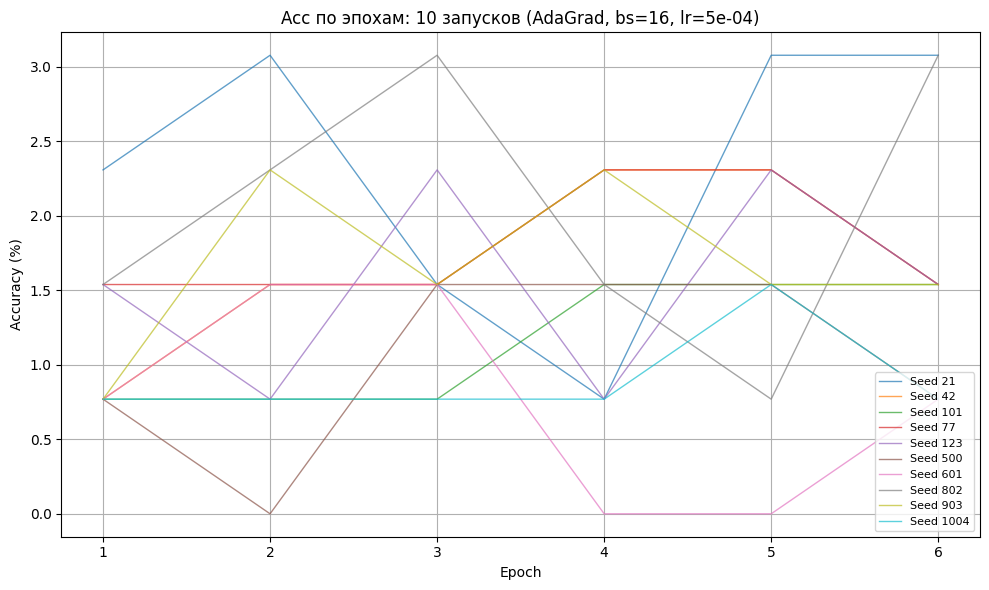

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

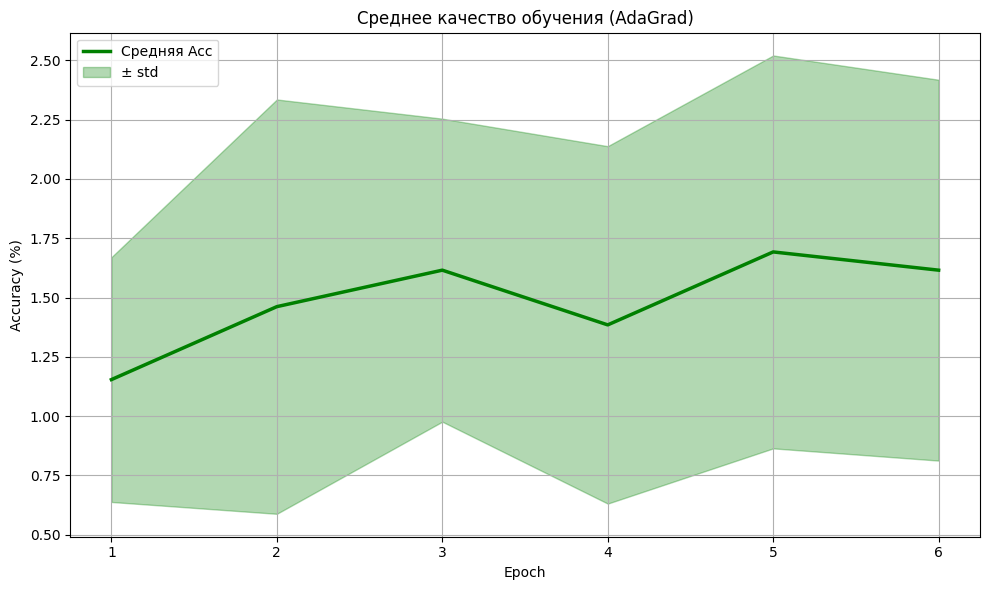

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

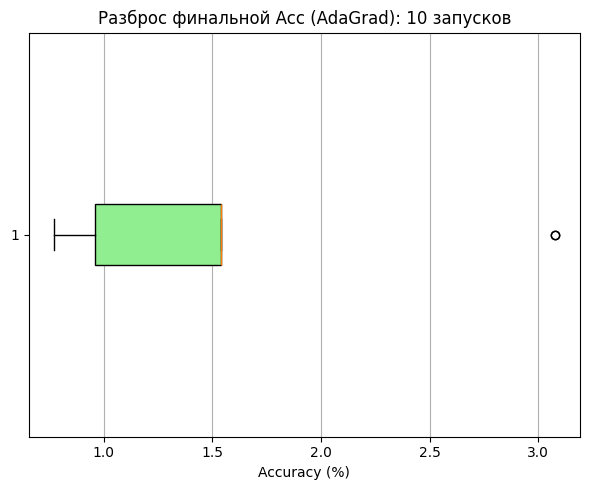

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

## RMSprop

In [ ]:
OPTIMIZER_NAME = "RMSprop"
OptimizerClass = torch.optim.RMSprop
opt_params_extra = {"alpha": 0.99}

OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")
            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.0527, Acc: 2.31%
    [Эпоха 2/6] Loss: 3.4582, Acc: 1.54%
    [Эпоха 3/6] Loss: 3.2255, Acc: 1.54%
    [Эпоха 4/6] Loss: 2.9248, Acc: 0.00%
    [Эпоха 5/6] Loss: 2.5601, Acc: 2.31%
    [Эпоха 6/6] Loss: 2.1615, Acc: 0.00%
  > BS=8, LR=1e-04, Seed=21: Acc = 2.31%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.0715, Acc: 1.54%
    [Эпоха 2/6] Loss: 3.4846, Acc: 1.54%
    [Эпоха 3/6] Loss: 3.1379, Acc: 2.31%
    [Эпоха 4/6] Loss: 2.7966, Acc: 0.77%
    [Эпоха 5/6] Loss: 2.3715, Acc: 0.77%
    [Эпоха 6/6] Loss: 1.9793, Acc: 2.31%
  > BS=8, LR=1e-04, Seed=42: Acc = 2.31%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")



Все результаты сохранены в ALL_RESULTS_RMSprop_full.json.


In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_RMSprop_full.json.
Лучшая конфигурация (RMSprop): BS=16, LR=1e-04 → Средняя Acc = 1.27%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (RMSprop): Acc = 1.23 ± 0.62%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

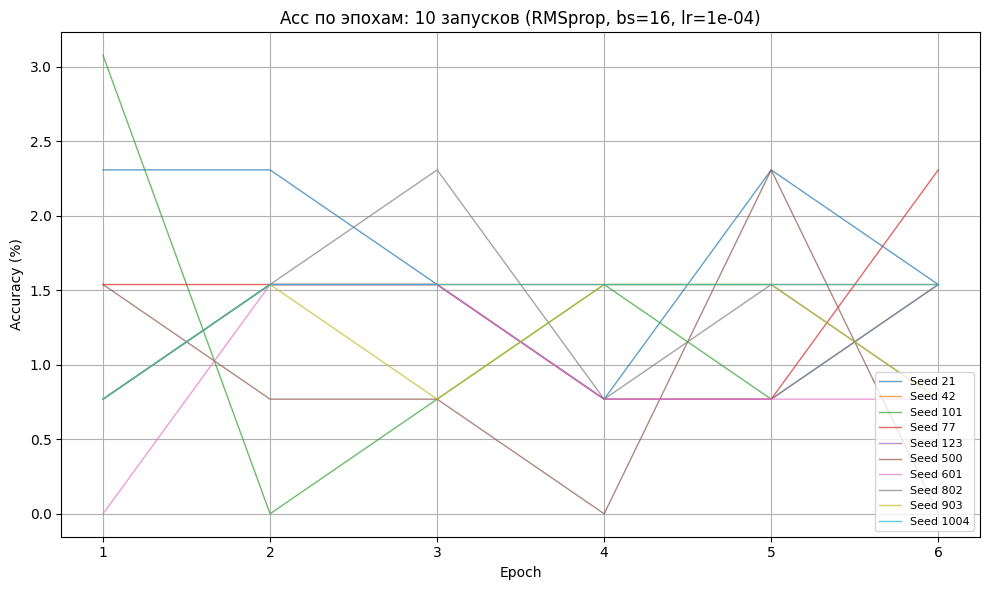

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

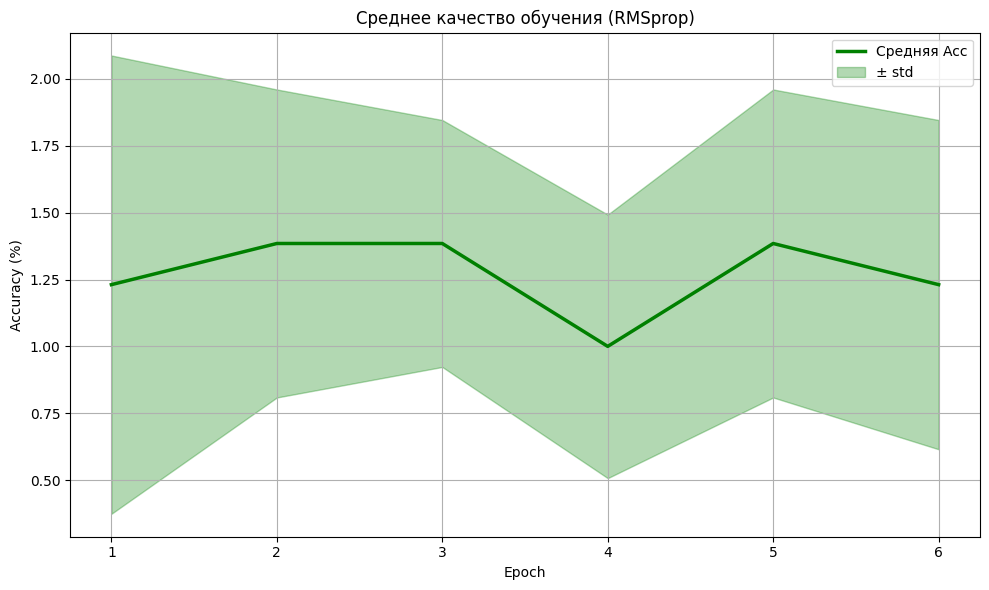

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

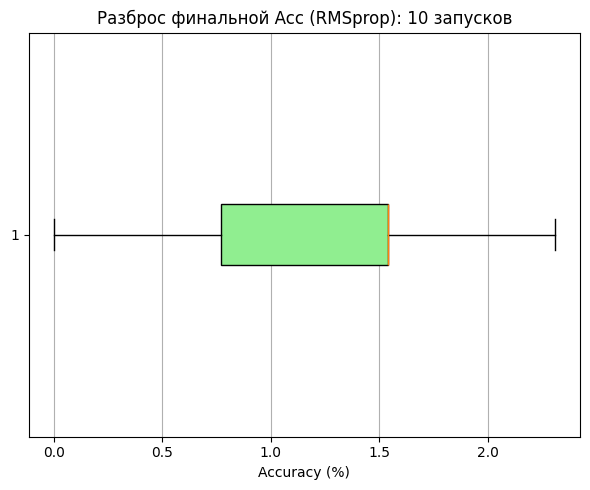

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

## AdamW

In [ ]:
OPTIMIZER_NAME = "AdamW"
OptimizerClass = torch.optim.AdamW
opt_params_extra = {"weight_decay": 1e-4}
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")
            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.2174, Acc: 1.54%
    [Эпоха 2/6] Loss: 3.4932, Acc: 3.08%
    [Эпоха 3/6] Loss: 3.2539, Acc: 1.54%
    [Эпоха 4/6] Loss: 2.9752, Acc: 2.31%
    [Эпоха 5/6] Loss: 2.7056, Acc: 3.85%
    [Эпоха 6/6] Loss: 2.3303, Acc: 2.31%
  > BS=8, LR=1e-04, Seed=21: Acc = 3.85%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.2103, Acc: 0.77%
    [Эпоха 2/6] Loss: 3.5163, Acc: 2.31%
    [Эпоха 3/6] Loss: 3.2399, Acc: 1.54%
    [Эпоха 4/6] Loss: 2.9806, Acc: 1.54%
    [Эпоха 5/6] Loss: 2.6847, Acc: 1.54%
    [Эпоха 6/6] Loss: 2.3767, Acc: 2.31%
  > BS=8, LR=1e-04, Seed=42: Acc = 2.31%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")



Все результаты сохранены в ALL_RESULTS_AdamW_full.json.


In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_AdamW_full.json.
Лучшая конфигурация (AdamW): BS=16, LR=5e-04 → Средняя Acc = 1.38%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (AdamW): Acc = 1.46 ± 0.80%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

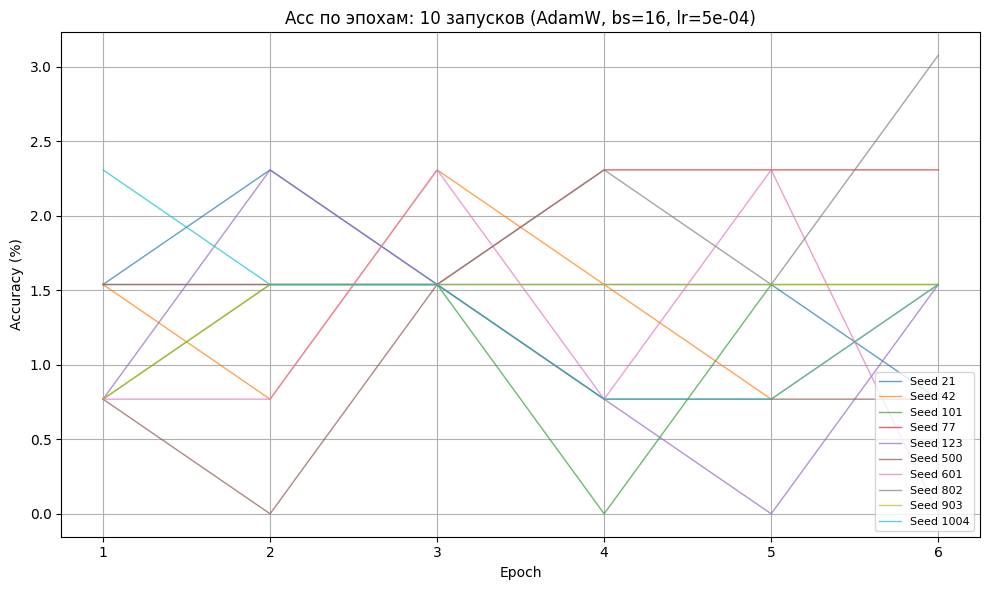

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

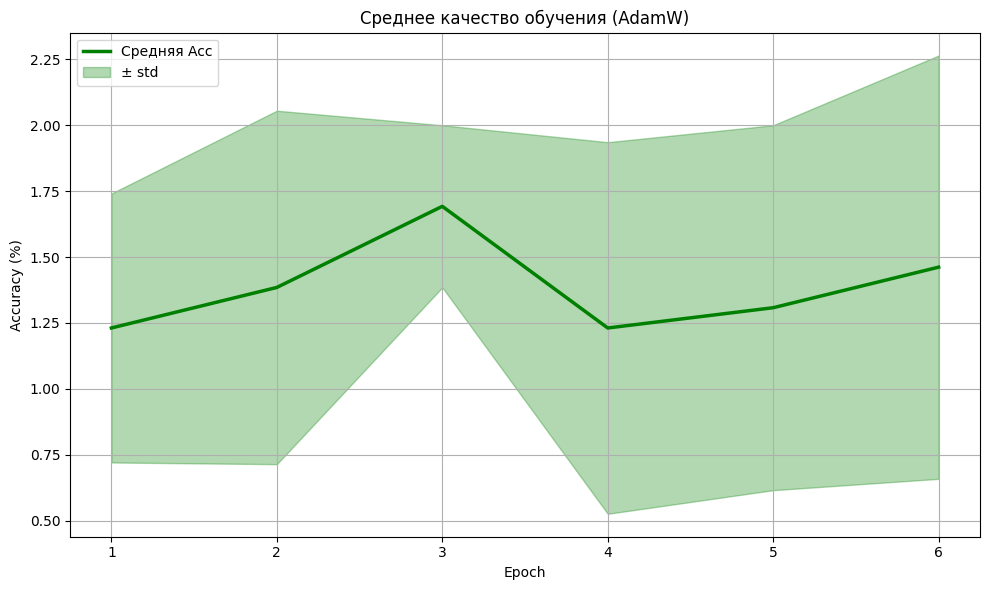

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

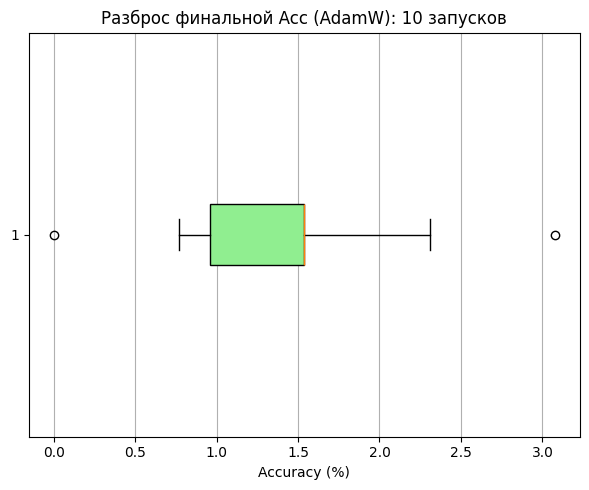

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

## Adadelta

In [ ]:
OPTIMIZER_NAME = "Adadelta"
OptimizerClass = torch.optim.Adadelta
opt_params_extra = {"rho": 0.9, "eps": 1e-6}

OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")
            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.9647, Acc: 1.54%
    [Эпоха 2/6] Loss: 4.9525, Acc: 0.77%
    [Эпоха 3/6] Loss: 4.9536, Acc: 0.77%
    [Эпоха 4/6] Loss: 4.9397, Acc: 1.54%
    [Эпоха 5/6] Loss: 4.9390, Acc: 0.77%
    [Эпоха 6/6] Loss: 4.9344, Acc: 1.54%
  > BS=8, LR=1e-04, Seed=21: Acc = 1.54%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.9081, Acc: 0.77%
    [Эпоха 2/6] Loss: 4.9007, Acc: 0.77%
    [Эпоха 3/6] Loss: 4.8937, Acc: 0.77%
    [Эпоха 4/6] Loss: 4.8928, Acc: 0.77%
    [Эпоха 5/6] Loss: 4.8841, Acc: 1.54%
    [Эпоха 6/6] Loss: 4.8740, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=42: Acc = 1.54%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")



Все результаты сохранены в ALL_RESULTS_Adadelta_full.json.


In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_Adadelta_full.json.
Лучшая конфигурация (Adadelta): BS=8, LR=5e-04 → Средняя Acc = 1.09%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (Adadelta): Acc = 1.08 ± 0.38%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

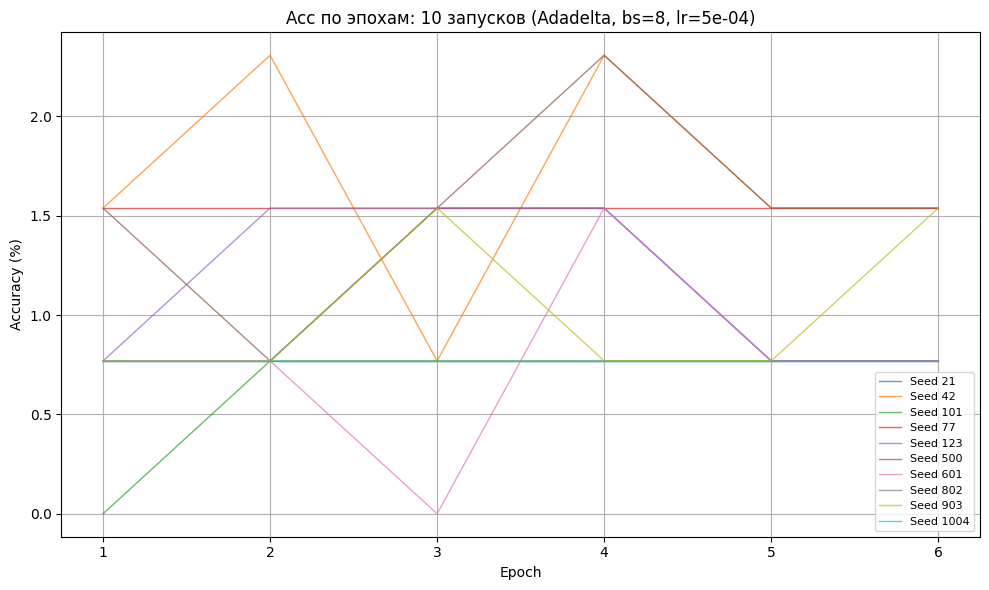

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

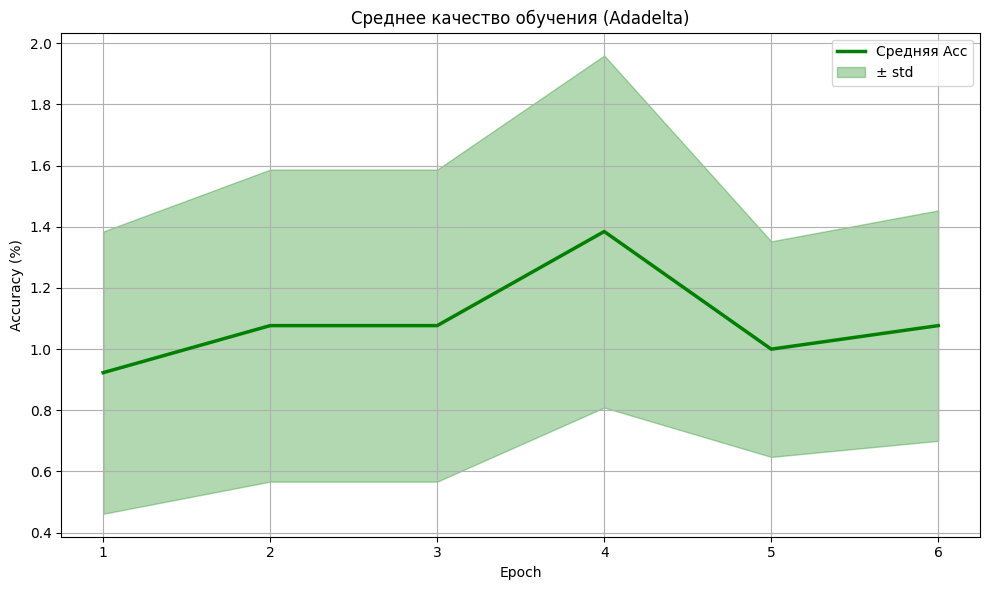

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

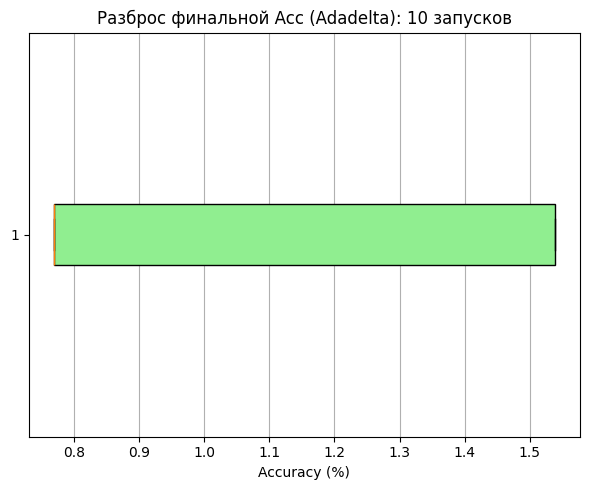

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

## Lion

In [ ]:
import torch
from torch.optim import Optimizer

class Lion(Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]

                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)

                exp_avg = state['exp_avg']
                beta1, beta2 = group['betas']
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)
                update = exp_avg.clone().sign_().mul_(group['lr'])
                p.add_(update, alpha=-1)
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

        return loss

OPTIMIZER_NAME = "Lion"

OptimizerClass = Lion
opt_params_extra = {"betas": (0.9, 0.99), "weight_decay": 1e-4}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")
            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.2458, Acc: 0.77%
    [Эпоха 2/6] Loss: 3.7858, Acc: 2.31%
    [Эпоха 3/6] Loss: 3.7180, Acc: 1.54%
    [Эпоха 4/6] Loss: 3.6494, Acc: 1.54%
    [Эпоха 5/6] Loss: 3.5748, Acc: 2.31%
    [Эпоха 6/6] Loss: 3.5370, Acc: 1.54%
  > BS=8, LR=1e-04, Seed=21: Acc = 2.31%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.1766, Acc: 0.77%
    [Эпоха 2/6] Loss: 3.8439, Acc: 0.77%
    [Эпоха 3/6] Loss: 3.7069, Acc: 1.54%
    [Эпоха 4/6] Loss: 3.6640, Acc: 0.77%
    [Эпоха 5/6] Loss: 3.5134, Acc: 0.77%
    [Эпоха 6/6] Loss: 3.5334, Acc: 1.54%
  > BS=8, LR=1e-04, Seed=42: Acc = 1.54%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")


from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_Lion_full.json.

Все результаты сохранены в ALL_RESULTS_Lion_full.json.
Лучшая конфигурация (Lion): BS=16, LR=1e-04 → Средняя Acc = 1.21%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (Lion): Acc = 1.08 ± 0.51%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

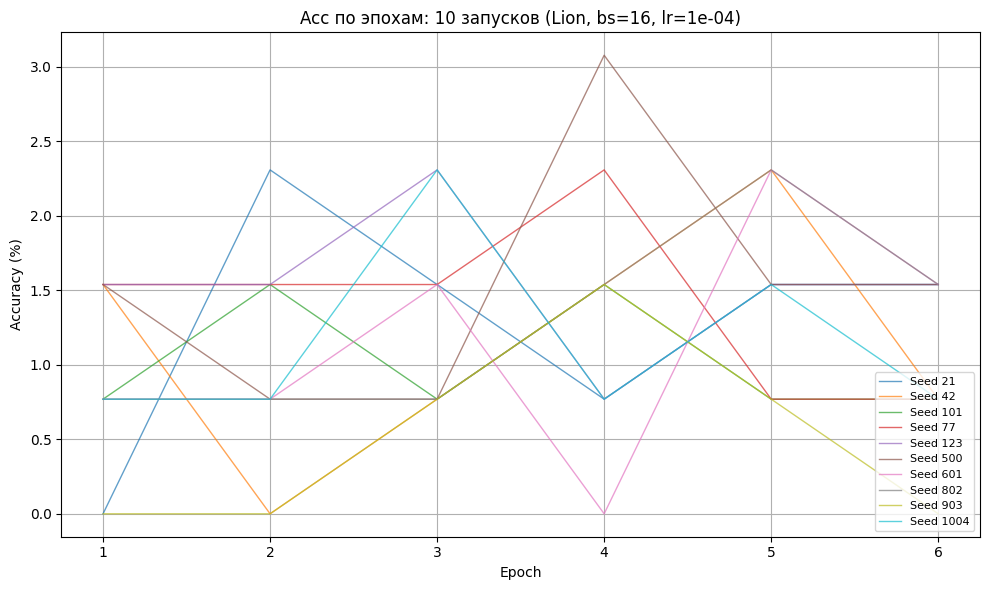

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

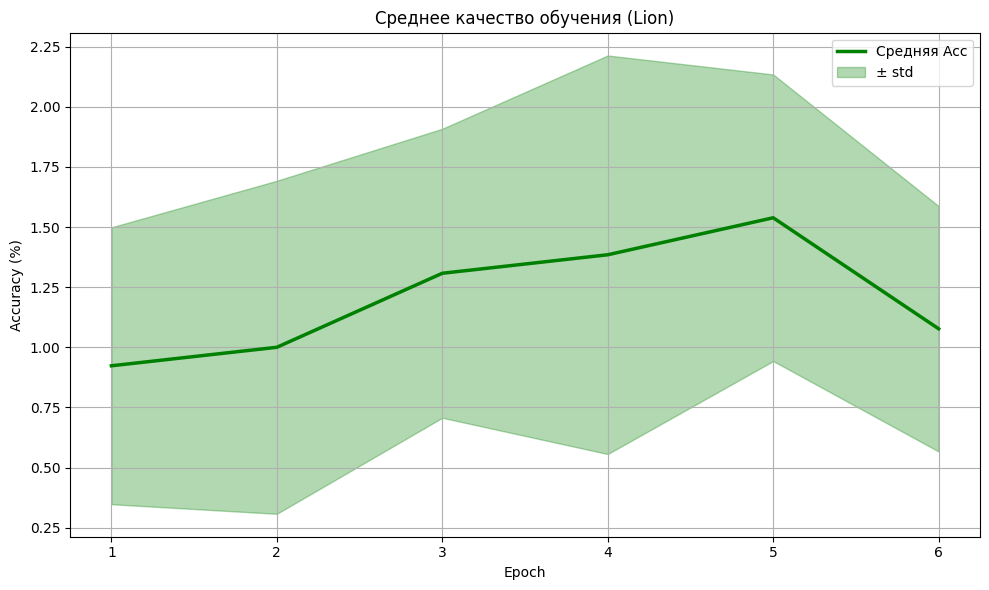

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

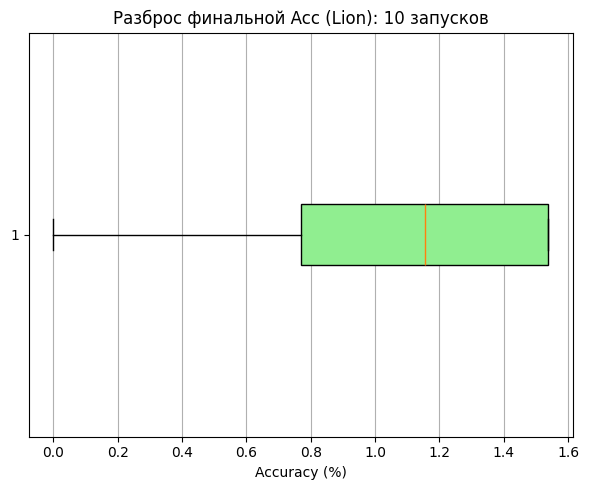

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

## SGD + Gradient Clipping - шумный

In [ ]:
class SGD_GCM(Optimizer):
    """
    SGD с momentum и градиентным клиппингом
    """
    def __init__(self, params, lr=1e-3, momentum=0.9, clip_norm=1.0):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= momentum < 1.0:
            raise ValueError(f"Invalid momentum: {momentum}")
        if not 0.0 <= clip_norm:
            raise ValueError(f"Invalid clip norm: {clip_norm}")
        defaults = dict(lr=lr, momentum=momentum, clip_norm=clip_norm)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                torch.nn.utils.clip_grad_norm_([p], max_norm=group['clip_norm'])
                state = self.state[p]
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(p)

                buf = state['momentum_buffer']
                buf.mul_(group['momentum']).add_(grad)
                p.add_(buf, alpha=-group['lr'])

        return loss


OPTIMIZER_NAME = "SGD_GCM"


OptimizerClass = SGD_GCM
opt_params_extra = {"momentum": 0.9, "clip_norm": 1.0}

In [ ]:
OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")
            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.9221, Acc: 0.77%
    [Эпоха 2/6] Loss: 4.7864, Acc: 1.54%
    [Эпоха 3/6] Loss: 4.6532, Acc: 2.31%
    [Эпоха 4/6] Loss: 4.5237, Acc: 0.77%
    [Эпоха 5/6] Loss: 4.4211, Acc: 0.77%
    [Эпоха 6/6] Loss: 4.3125, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=21: Acc = 2.31%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.8632, Acc: 1.54%
    [Эпоха 2/6] Loss: 4.7270, Acc: 2.31%
    [Эпоха 3/6] Loss: 4.6044, Acc: 0.77%
    [Эпоха 4/6] Loss: 4.4805, Acc: 0.77%
    [Эпоха 5/6] Loss: 4.3758, Acc: 0.77%
    [Эпоха 6/6] Loss: 4.2723, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=42: Acc = 2.31%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")



Все результаты сохранены в ALL_RESULTS_SGD_GCM_full.json.


In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_SGD_GCM_full.json.
Лучшая конфигурация (SGD_GCM): BS=16, LR=1e-04 → Средняя Acc = 1.01%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (SGD_GCM): Acc = 0.92 ± 0.46%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

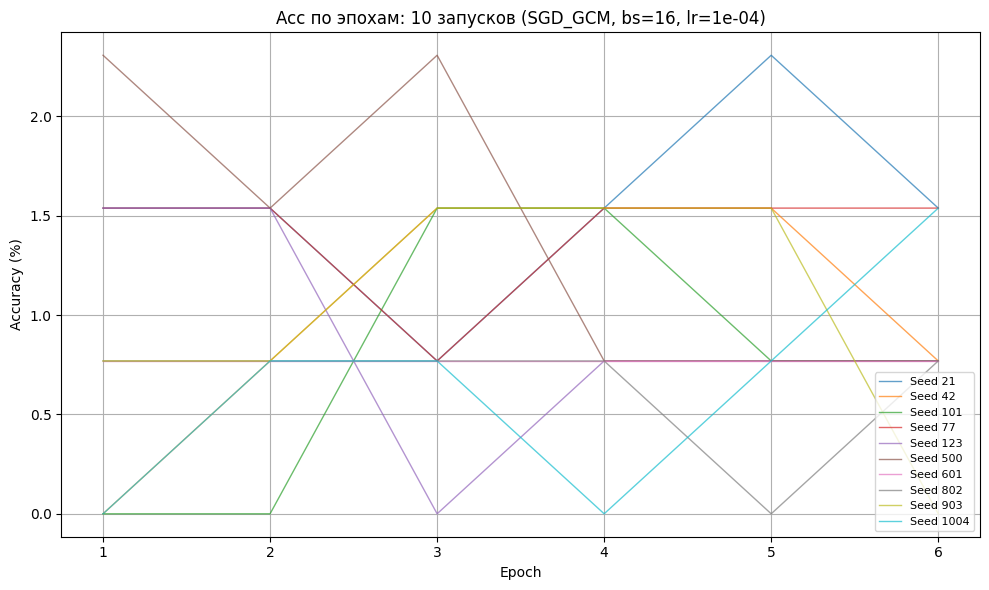

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

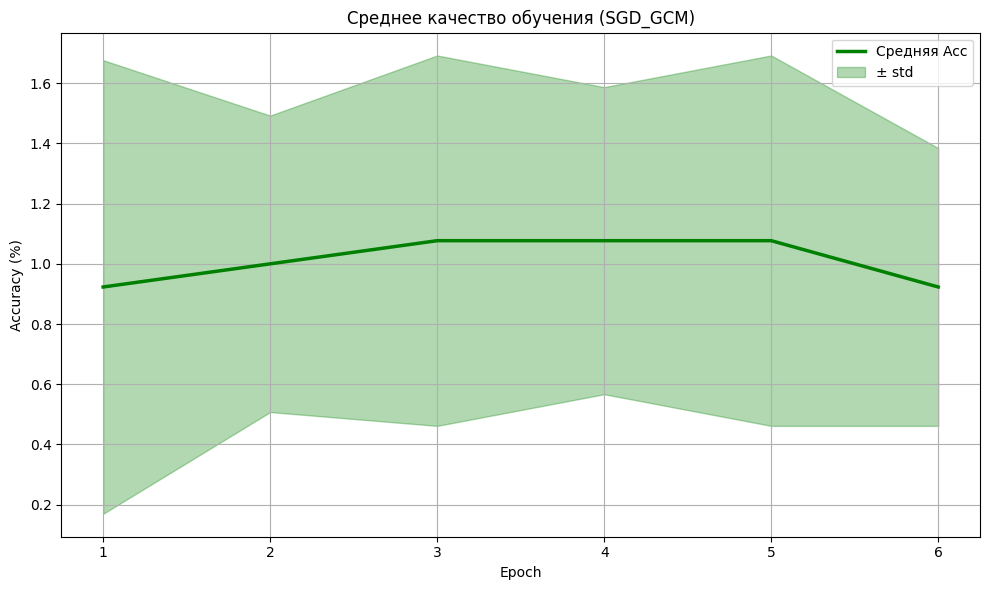

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

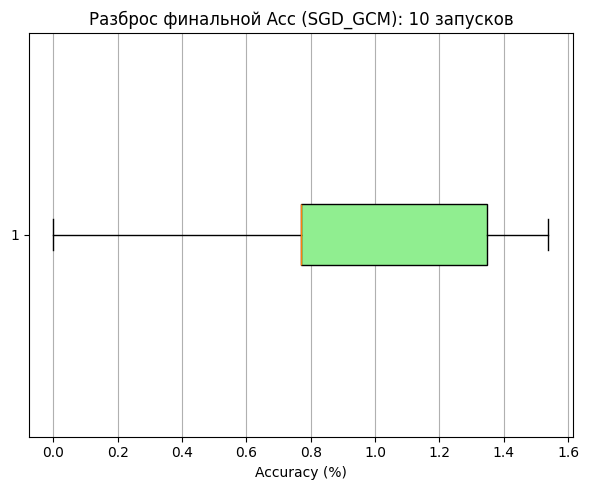

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

## Adaptive Gradient Clipping - шумный

In [ ]:
class AGC_Optimizer(Optimizer):
    """
    Обёртка над SGD, применяющая Adaptive Gradient Clipping (AGC)
    """
    def __init__(self, params, lr=1e-3, momentum=0.9, clip_factor=0.01, eps=1e-3):
        defaults = dict(lr=lr, momentum=momentum, clip_factor=clip_factor, eps=eps)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]
                param_norm = p.data.norm().clamp(min=group['eps'])
                grad_norm = grad.norm().clamp(min=group['eps'])
                clip_coef = group['clip_factor'] * param_norm / (grad_norm + group['eps'])
                if clip_coef < 1:
                    grad = grad * clip_coef
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(p)

                buf = state['momentum_buffer']
                buf.mul_(group['momentum']).add_(grad)
                p.add_(buf, alpha=-group['lr'])

        return loss

OPTIMIZER_NAME = "AGC_SGD"

OptimizerClass = AGC_Optimizer
opt_params_extra = {"momentum": 0.9, "clip_factor": 0.01, "eps": 1e-3}

In [ ]:


OPT_DIR = os.path.join(EXPERIMENT_ROOT, OPTIMIZER_NAME)
os.makedirs(os.path.join(OPT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OPT_DIR, "plots"), exist_ok=True)

all_experiment_results: List[Dict[str, Any]] = []

In [ ]:
for bs in batch_sizes:
    for lr in learning_rates:
        for seed in SEEDS:
            log_filename = f"{OPTIMIZER_NAME}_bs{bs}_lr{lr:.0e}_seed{seed}.csv"
            log_file_path = os.path.join(OPT_DIR, "logs", log_filename)
            with open(log_file_path, 'w') as f:
                f.write("epoch,train_loss,acc\n")
            result_dict = run_single_experiment_cls(
                task_name=TASK_NAME,
                optimizer_name=OPTIMIZER_NAME,
                batch_size=bs,
                learning_rate=lr,
                epochs=EPOCHS,
                seed=seed,
                log_file_path=log_file_path,
                ModelClass=create_resnet18_lsq,
                OptimizerClass=OptimizerClass,
                device=device,
                opt_params_extra=opt_params_extra
            )
            if result_dict:
                all_experiment_results.append(result_dict)
                print(f"  > BS={bs}, LR={lr:.0e}, Seed={seed}: Acc = {result_dict['best_metric']:.2f}%")


Запуск (BS=8, LR=1.0e-04, Seed=21)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.9644, Acc: 0.77%
    [Эпоха 2/6] Loss: 4.9480, Acc: 0.77%
    [Эпоха 3/6] Loss: 4.9410, Acc: 0.77%
    [Эпоха 4/6] Loss: 4.9214, Acc: 0.77%
    [Эпоха 5/6] Loss: 4.9146, Acc: 0.77%
    [Эпоха 6/6] Loss: 4.8988, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=21: Acc = 0.77%

Запуск (BS=8, LR=1.0e-04, Seed=42)
Загружено 566 изображений (1% из каждого класса)
Число классов: 130
Загружено 130 изображений (1% из каждого класса)
Число классов: 130
    [Эпоха 1/6] Loss: 4.9086, Acc: 0.77%
    [Эпоха 2/6] Loss: 4.8928, Acc: 0.77%
    [Эпоха 3/6] Loss: 4.8817, Acc: 0.77%
    [Эпоха 4/6] Loss: 4.8736, Acc: 0.77%
    [Эпоха 5/6] Loss: 4.8595, Acc: 1.54%
    [Эпоха 6/6] Loss: 4.8439, Acc: 0.77%
  > BS=8, LR=1e-04, Seed=42: Acc = 1.54%

Запуск (BS=8, LR=1.0e-04, Seed=101)
Загружено 566 изображений (1% из каждого клас

In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")



Все результаты сохранены в ALL_RESULTS_AGC_SGD_full.json.


In [ ]:
from collections import defaultdict

search_results_filename = f"ALL_RESULTS_{OPTIMIZER_NAME}_full.json"
with open(os.path.join(OPT_DIR, search_results_filename), "w") as f:
    json.dump(all_experiment_results, f, indent=2)
print(f"\nВсе результаты сохранены в {search_results_filename}.")

config_stats = defaultdict(list)
for res in all_experiment_results:
    key = (res['batch_size'], res['learning_rate'])
    config_stats[key].append(res['mean_metric_all_epochs'])

best_key = None
best_mean = -float('inf')
for (bs, lr), accs in config_stats.items():
    if len(accs) == len(SEEDS):
        avg_acc = np.mean(accs)
        if avg_acc > best_mean:
            best_mean = avg_acc
            best_key = (bs, lr)

if best_key is None:
    raise RuntimeError("Ни одна конфигурация не завершилась полностью.")

best_bs, best_lr = best_key
print(f"Лучшая конфигурация ({OPTIMIZER_NAME}): BS={best_bs}, LR={best_lr:.0e} → Средняя Acc = {best_mean:.2f}%")


Все результаты сохранены в ALL_RESULTS_AGC_SGD_full.json.
Лучшая конфигурация (AGC_SGD): BS=8, LR=1e-03 → Средняя Acc = 1.10%


In [ ]:
final_runs_full = [
    res for res in all_experiment_results
    if res['batch_size'] == best_bs and res['learning_rate'] == best_lr
]

final_accs_full = [run['final_metric'] for run in final_runs_full]
mean_final = np.mean(final_accs_full)
std_final = np.std(final_accs_full)

print(f"Финальный результат ({OPTIMIZER_NAME}): Acc = {mean_final:.2f} ± {std_final:.2f}%")

Финальный результат (AGC_SGD): Acc = 1.31 ± 0.49%


In [ ]:
summary = {
    "optimizer": OPTIMIZER_NAME,
    "best_config": {
        "batch_size": best_bs,
        "learning_rate": best_lr,
        "mean_acc_10seeds": float(best_mean),
    },
    "final_run": {
        "mean_acc_final_epoch": float(mean_final),
        "std_acc_final_epoch": float(std_final),
        "all_final_accs": [float(a) for a in final_accs_full]
    }
}
with open(os.path.join(OPT_DIR, "SUMMARY.json"), "w") as f:
    json.dump(summary, f, indent=2)

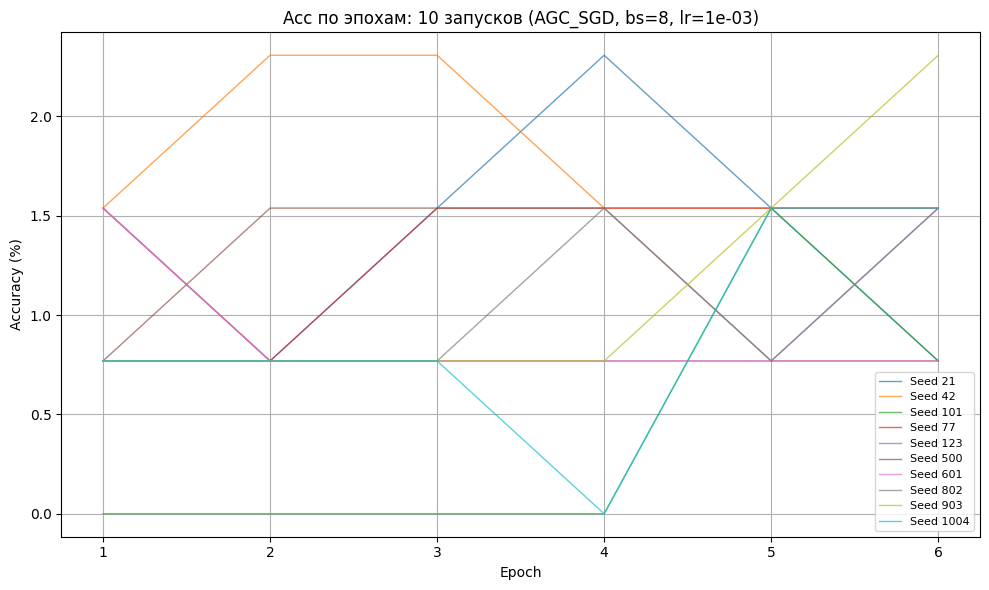

In [ ]:
plt.figure(figsize=(10, 6))
for run_data in final_runs_full:
    epochs = range(1, len(run_data['metric_history']) + 1)
    plt.plot(epochs, run_data['metric_history'], alpha=0.7, linewidth=1, label=f'Seed {run_data["seed"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Acc по эпохам: 10 запусков ({OPTIMIZER_NAME}, bs={best_bs}, lr={best_lr:.0e})')
plt.grid(True)
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "all_runs_acc.png"), dpi=150)
plt.show()

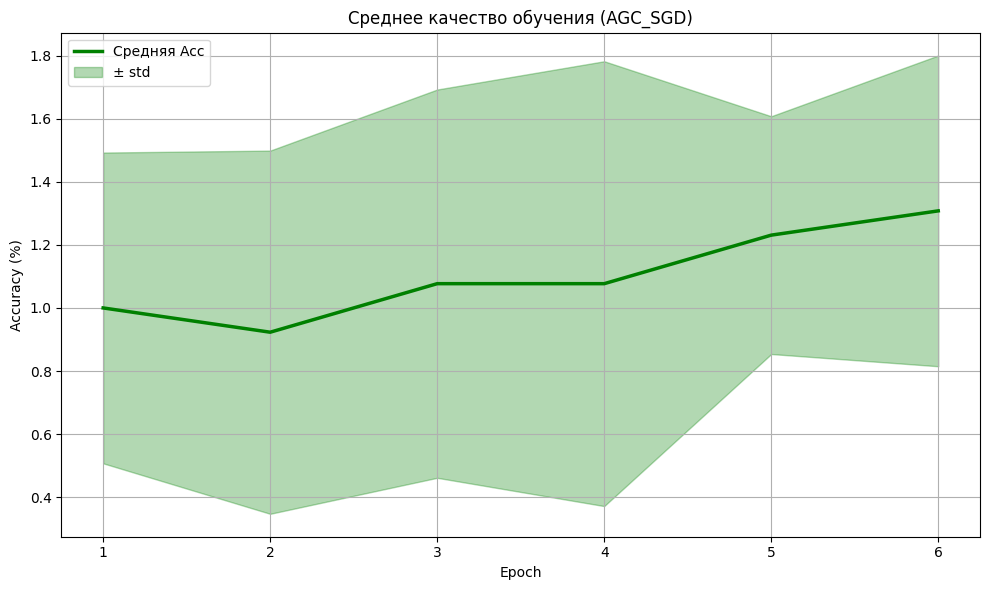

In [ ]:
all_acc_curves = np.array([run['metric_history'] for run in final_runs_full])
mean_acc = np.mean(all_acc_curves, axis=0)
std_acc = np.std(all_acc_curves, axis=0)

plt.figure(figsize=(10, 6))
epochs = range(1, len(mean_acc) + 1)
plt.plot(epochs, mean_acc, color='green', linewidth=2.5, label='Средняя Acc')
plt.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color='green', alpha=0.3, label='± std')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Среднее качество обучения ({OPTIMIZER_NAME})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "mean_std_acc.png"), dpi=150)
plt.show()

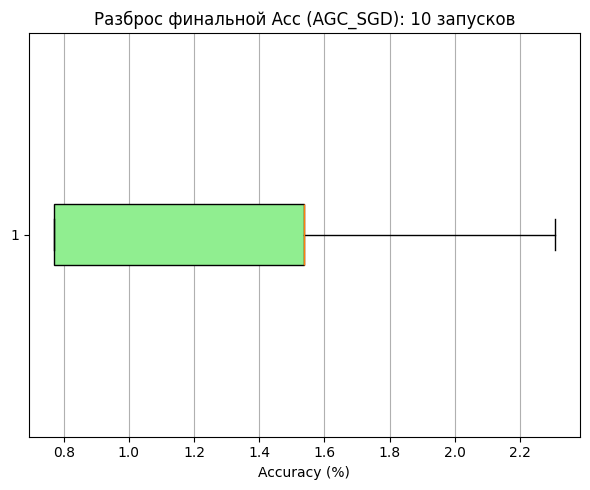

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(final_accs_full, vert=False, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
plt.xlabel('Accuracy (%)')
plt.title(f'Разброс финальной Acc ({OPTIMIZER_NAME}): 10 запусков')
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig(os.path.join(OPT_DIR, "plots", "final_acc_boxplot.png"), dpi=150)
plt.show()

# Итог

In [ ]:
import json
import os
import pandas as pd

results_dir = "/content/result"

all_runs = []
for filename in os.listdir(results_dir):
    if filename.endswith(".json"):
        with open(os.path.join(results_dir, filename), "r") as f:
            data = json.load(f)
            if isinstance(data, list):
                all_runs.extend(data)
            else:
                all_runs.append(data)
df = pd.DataFrame(all_runs)
df.head()

,run_id,task_name,model_name,optimizer,batch_size,learning_rate,epochs,seed,log_file_path,mean_metric_all_epochs,best_metric,best_epoch,final_metric,total_time_sec,metric_history,loss_history
0,65633257-16ff-4d61-a7bd-25d43e332ff4,Classification,ResNet18_LSQ,Adadelta,8,0.0001,6,21,/content/drive/MyDrive/CLS_ResNet18_LSQ_Experi...,1.153846,1.538462,1,1.538462,35.71,"[1.5384615384615385, 0.7692307692307693, 0.769...","[4.964744621789077, 4.95253131414892, 4.953619..."
1,0ec06e03-34cb-47a8-a2f9-7cabdae24ce6,Classification,ResNet18_LSQ,Adadelta,8,0.0001,6,42,/content/drive/MyDrive/CLS_ResNet18_LSQ_Experi...,0.897436,1.538462,5,0.769231,34.51,"[0.7692307692307693, 0.7692307692307693, 0.769...","[4.908072085768089, 4.900736128062325, 4.89372..."
2,dc233b34-a7d4-401c-a38f-fe479201564a,Classification,ResNet18_LSQ,Adadelta,8,0.0001,6,101,/content/drive/MyDrive/CLS_ResNet18_LSQ_Experi...,0.000000,0.000000,1,0.000000,35.36,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[5.065333356284421, 5.056378150575995, 5.05608..."
3,59b377db-b2da-4d59-9e07-97a5da20203c,Classification,ResNet18_LSQ,Adadelta,8,0.0001,6,77,/content/drive/MyDrive/CLS_ResNet18_LSQ_Experi...,1.282051,1.538462,1,1.538462,34.29,"[1.5384615384615385, 0.7692307692307693, 0.769...","[4.989667307782931, 4.990244868787355, 4.97949..."
4,1754aedc-27fe-40cc-8f46-bf80783786e1,Classification,ResNet18_LSQ,Adadelta,8,0.0001,6,123,/content/drive/MyDrive/CLS_ResNet18_LSQ_Experi...,1.410256,1.538462,2,1.538462,35.56,"[0.7692307692307693, 1.5384615384615385, 1.538...","[5.071396084640557, 5.059699262410087, 5.06158..."


In [ ]:
# Группируем и считаем статистики
summary = df.groupby(['optimizer', 'batch_size', 'learning_rate'])['final_metric'].agg(
    mean='mean',
    std='std',
    min='min',
    max='max',
    median='median',
    count='count'  # должно быть 10
).round(3).reset_index()

# Сортируем по среднему результату (лучшие сверху)
summary = summary.sort_values('mean', ascending=False)
summary

,optimizer,batch_size,learning_rate,mean,std,min,max,median,count
11,AdaGrad,16,0.0010,1.769,1.497,0.000,4.615,1.154,10
8,AdaGrad,8,0.0010,1.615,0.674,0.769,2.308,1.538,10
10,AdaGrad,16,0.0005,1.615,0.847,0.769,3.077,1.538,10
23,Adam,16,0.0010,1.615,0.990,0.769,3.846,1.538,10
29,AdamW,16,0.0010,1.462,0.568,0.769,2.308,1.538,10
28,AdamW,16,0.0005,1.462,0.847,0.000,3.077,1.538,10
19,Adam,8,0.0005,1.385,0.794,0.769,3.077,1.154,10
7,AdaGrad,8,0.0005,1.385,1.013,0.000,3.077,1.538,10
25,AdamW,8,0.0005,1.308,0.519,0.769,2.308,1.538,10
42,RMSprop,8,0.0001,1.308,0.815,0.000,2.308,1.154,10


In [ ]:
best_per_optimizer = df.groupby('optimizer')['final_metric'].max().sort_values(ascending=False)
best_per_optimizer

,final_metric
optimizer,
AdaGrad,4.615385
Adam,3.846154
AdamW,3.076923
AGC_SGD,2.307692
Adadelta,2.307692
Lion,2.307692
Nesterov,2.307692
RMSprop,2.307692
SGD,2.307692


In [ ]:
idx_best = df.groupby('optimizer')['final_metric'].idxmax()
df.loc[idx_best, ['optimizer', 'batch_size', 'learning_rate', 'final_metric']].sort_values('final_metric', ascending=False)

,optimizer,batch_size,learning_rate,final_metric
477,AdaGrad,16,0.0010,4.615385
292,Adam,16,0.0010,3.846154
501,AdamW,8,0.0010,3.076923
310,AGC_SGD,8,0.0005,2.307692
35,Adadelta,16,0.0001,2.307692
168,Lion,16,0.0005,2.307692
203,Nesterov,8,0.0010,2.307692
361,RMSprop,8,0.0001,2.307692
560,SGD,8,0.0010,2.307692
62,SGD_GCM,8,0.0001,1.538462
